In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [2]:
housing = pd.read_csv("/kaggle/input/housing-price-analysis/final_OneHotEncoded_housing.csv")

In [3]:
housing = housing.dropna(subset=['Price (in rupees)'])  # Delete all missing value

In [4]:
# Prepare features (X) and target (y)
x = housing.drop(columns=['Price (in rupees)'])
y = housing['Price (in rupees)']

In [5]:
from sklearn.preprocessing import StandardScaler

# 1. Handle outliers
def preprocess_target(y):
    # Remove zeros and extreme outliers
    min_value = 100  # Minimum reasonable price as some value are not reflecting the real price
    max_value = y.max()
    return np.clip(y, min_value, max_value)

# 2. Log transform the target variable
def transform_target(y):
    return np.log1p(y)

# 3. Preprocess features
def preprocess_features(x):
    scaler = StandardScaler()
    numeric_cols = x.select_dtypes(include=['int64', 'float64']).columns
    x_processed = x.copy()
    x_processed[numeric_cols] = scaler.fit_transform(x_processed[numeric_cols])
    return x_processed, scaler

# Preprocess the data
y_processed = preprocess_target(y)
y_transformed = transform_target(y_processed)
x_processed, scaler = preprocess_features(x)

In [6]:
# Split the data
x_temp, x_test, y_temp, y_test = train_test_split(
    x_processed, y_transformed,
    test_size=0.2,
    random_state=625 # Ensure
)

# Second split: create validation set from remaining data (20% of original data)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, 
    test_size=0.25, 
    random_state=625)

## Fit the random forest with hyper-parameter tuning

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define refined parameter distributions
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(3, 16)),
    'learning_rate': uniform(0.05, 0.25),
    'num_leaves': randint(31, 255),  # 31 is default, 255 is max recommended
    'subsample': uniform(0.6, 0.35),  # range 0.6-0.95
    'colsample_bytree': uniform(0.6, 0.35),  # range 0.6-0.95
    'min_child_samples': randint(10, 100),
    'min_child_weight': uniform(1e-5, 1.0),
    'reg_alpha': uniform(0, 1.0),  # L1 regularization
    'reg_lambda': uniform(0, 1.0),  # L2 regularization
}


# Create model with GPU support and some base parameters
model = lgb.LGBMRegressor(
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=-1,
    silent=True,
    boost_from_average=True,
    force_row_wise=True
)


# Random search setup
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=25,  # Increased from 10 to explore more combinations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # Keep at 1 for GPU
    verbose=1,
    random_state=625,  # For reproducibility
)

# Create evaluation dataset
eval_set = [(x_val, y_val)]

# Fit parameters
fit_params = {
    "eval_set": eval_set,
    "eval_metric": "rmse",
    "callbacks": [early_stopping(stopping_rounds=50, verbose=False)]
}


random_search.fit(x_train, y_train, **fit_params)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Get feature importances from best model, handling any NA values
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': random_search.best_estimator_.feature_importances_
})

Fitting 5 folds for each of 25 candidates, totalling 125 fits


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Best parameters: {'colsample_bytree': 0.6247760112123145, 'learning_rate': 0.06882937560025328, 'max_depth': None, 'min_child_samples': 42, 'min_child_weight': 0.10049173534366289, 'n_estimators': 648, 'num_leaves': 84, 'reg_alpha': 0.32783800639660143, 'reg_lambda': 0.3461359951545572, 'subsample': 0.6413839189355055}
Best score: -0.0658594016877031


In [8]:
# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# If you're predicting prices, calculate percentage errors
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

print("\nTest Set Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Create a DataFrame with actual vs predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Absolute_Error': np.abs(y_test - y_pred),
    'Percentage_Error': np.abs((y_test - y_pred) / y_test) * 100
})

# Show some statistics about the predictions
print("\nPrediction Analysis:")
print(results_df.describe())


Test Set Performance Metrics:
R² Score: 0.7588
RMSE: 0.26
MAE: 0.13
MAPE: 1.47%

Prediction Analysis:
             Actual     Predicted  Absolute_Error  Percentage_Error
count  33965.000000  33965.000000    33965.000000      33965.000000
mean       8.762648      8.764005        0.127011          1.471726
std        0.527890      0.460347        0.226013          2.648279
min        5.123964      7.590318        0.000002          0.000018
25%        8.367997      8.429425        0.001963          0.021845
50%        8.705331      8.682578        0.010075          0.116231
75%        9.145909      9.026394        0.166598          1.937403
max       11.250573     10.785243        3.543551         69.156440


/tmp/ipykernel_30/1923314920.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'Predicted vs Actual Values')

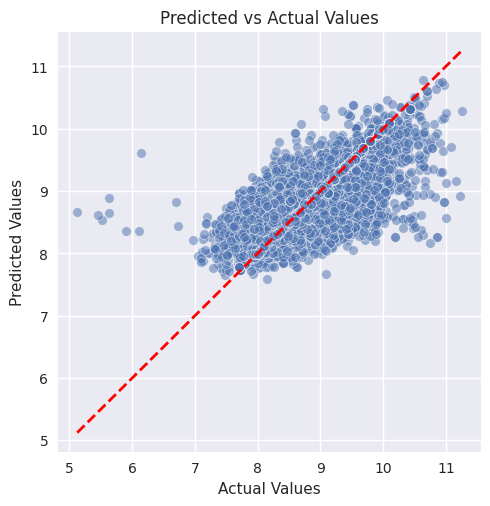

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for better visualization
plt.style.use('seaborn')
fig_size = (12, 12)

# Actual vs Predicted Scatter Plot
# Create figure with subplots
fig = plt.figure(figsize=fig_size)
    
# 1. Scatter plot of predicted vs actual values
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    
# Add diagonal line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

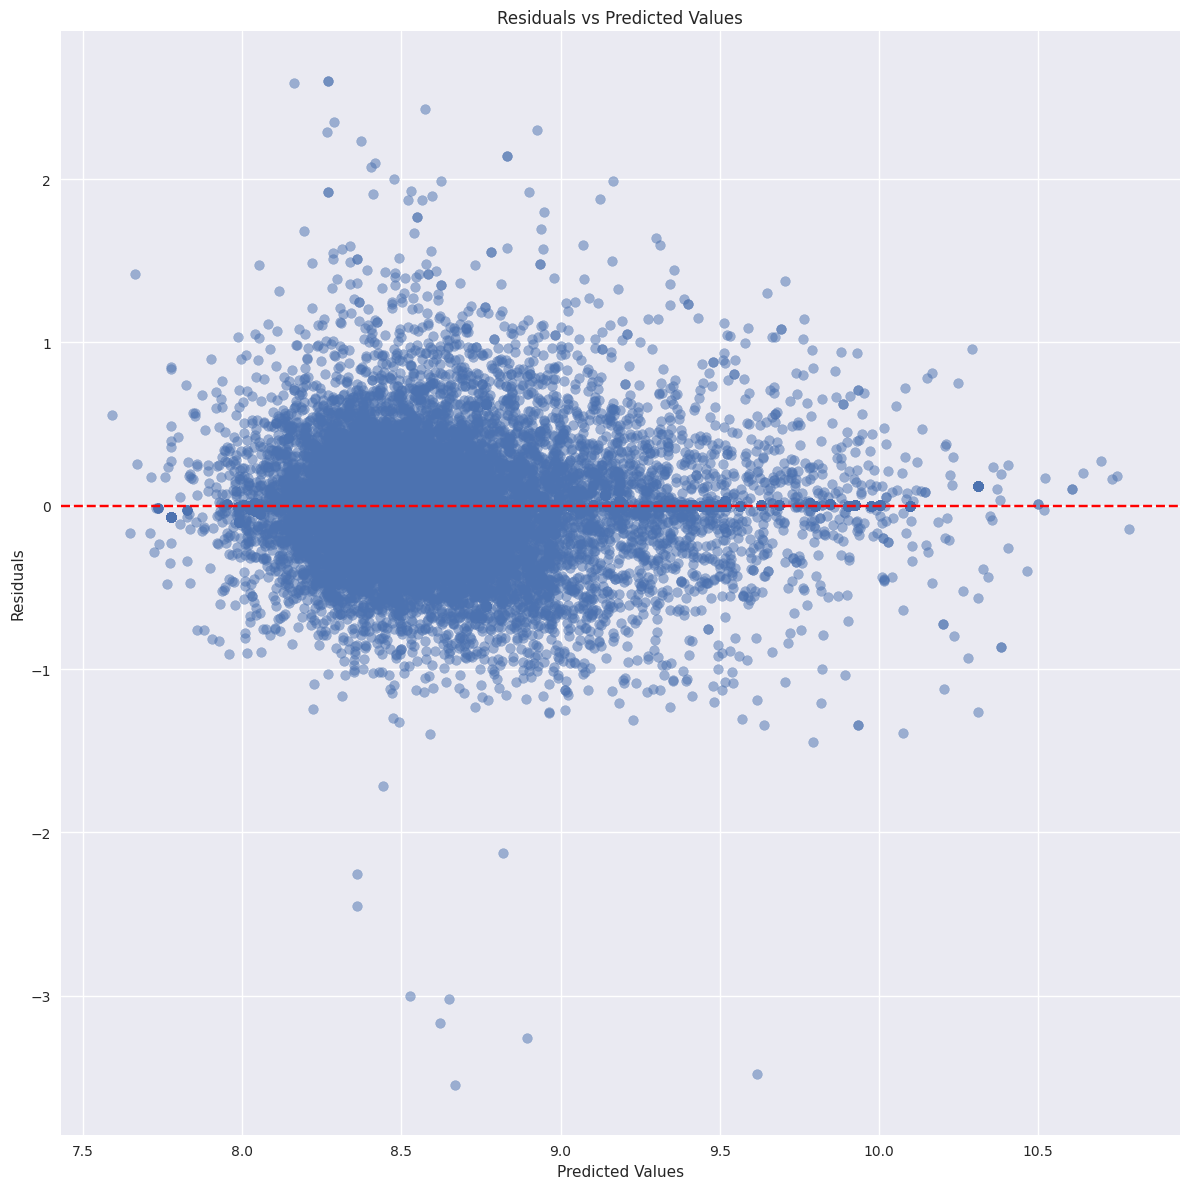

In [10]:
# 2. Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=fig_size)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


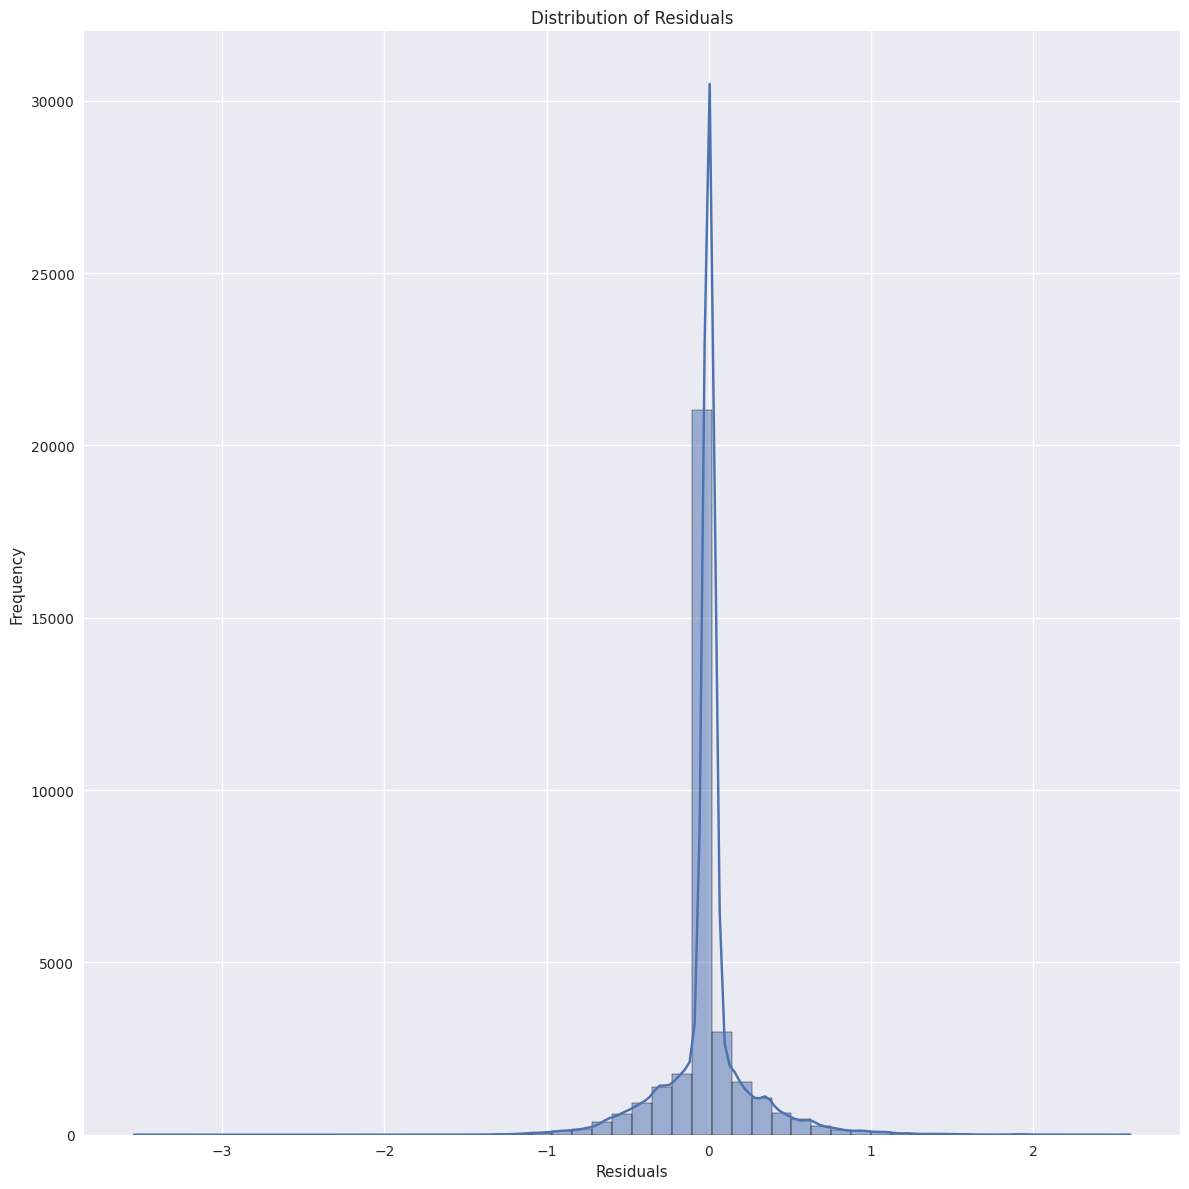

In [11]:
# 3. Residuals Distribution
plt.figure(figsize=fig_size)
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


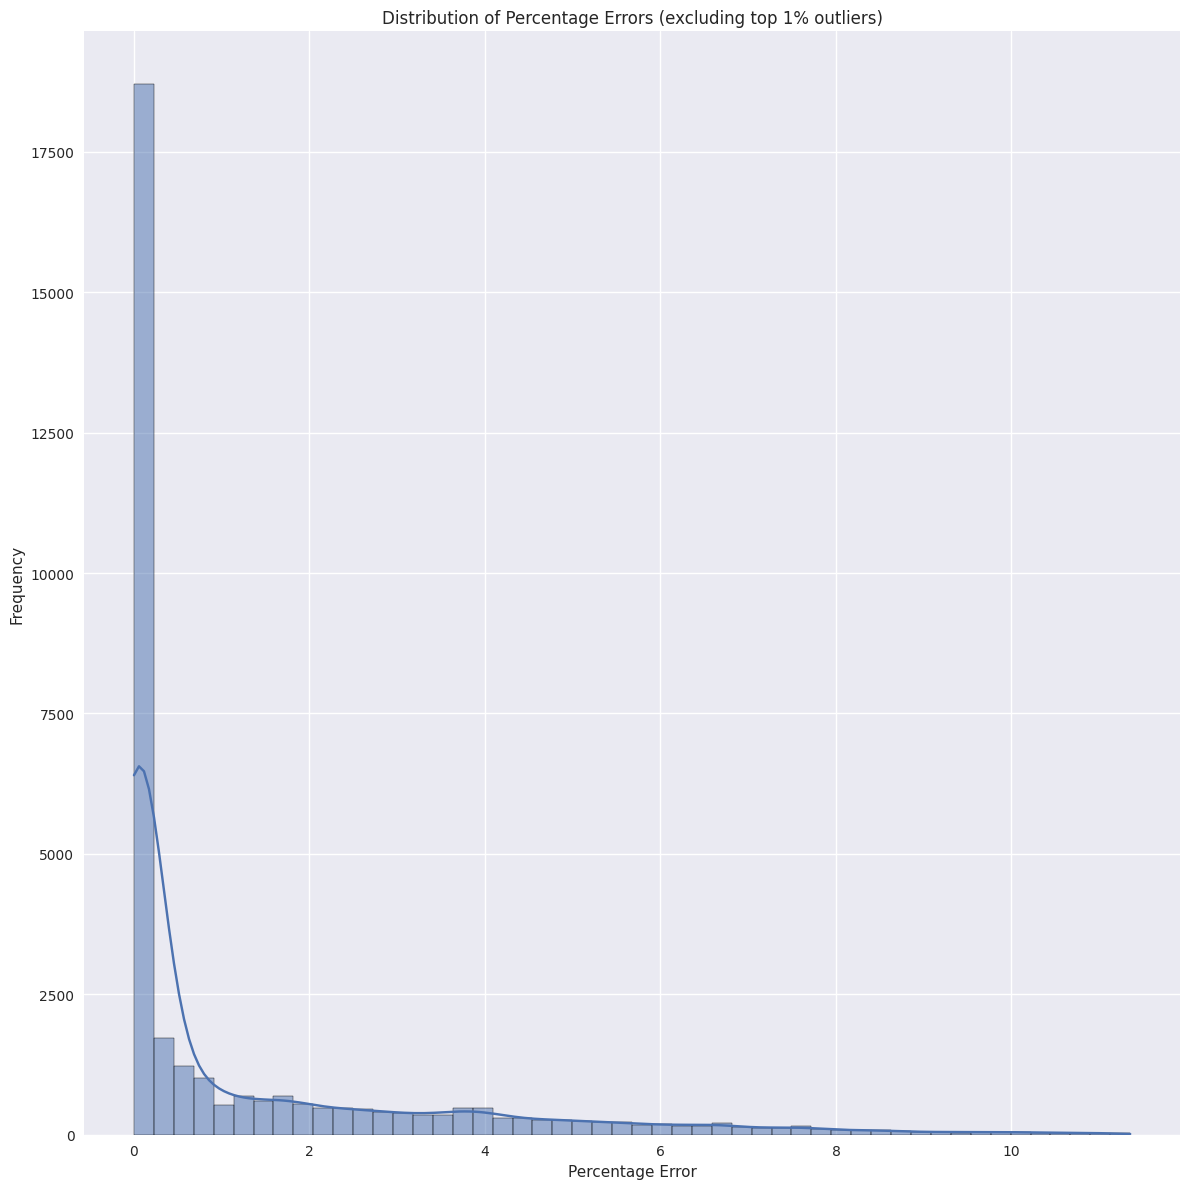

In [12]:
# 4. Percentage Error Distribution
percentage_error = np.abs((y_test - y_pred) / y_test) * 100
plt.figure(figsize=fig_size)
sns.histplot(percentage_error[percentage_error < np.percentile(percentage_error, 99)], bins=50, kde=True)
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Errors (excluding top 1% outliers)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_30/101596475.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return error_by_bin.groupby('Price_Range')['Mean_Absolute_Error'].mean()


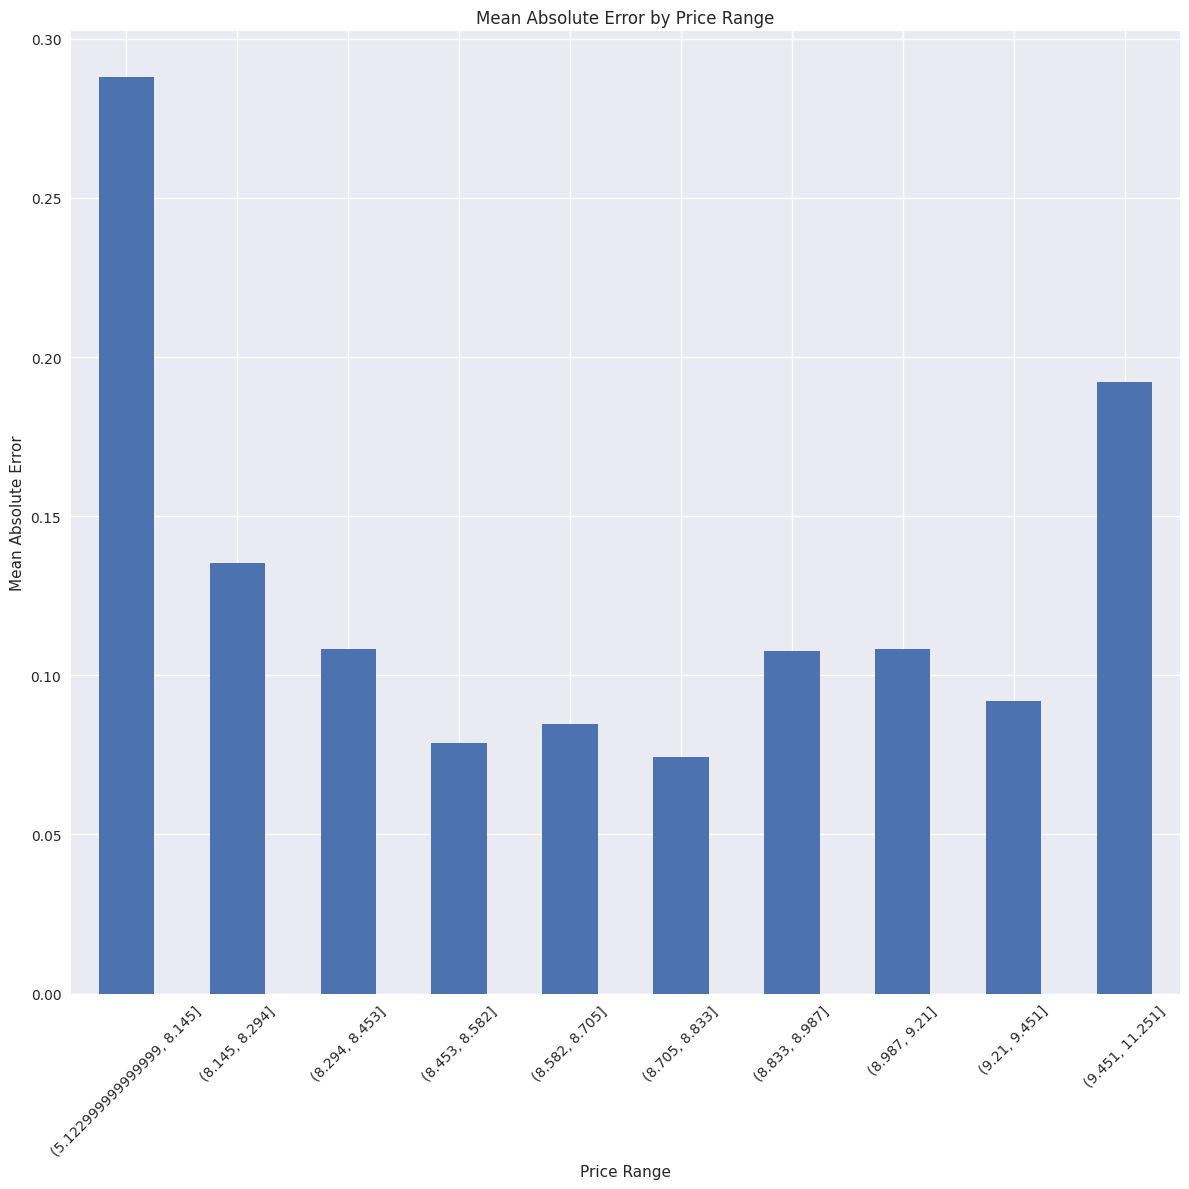

In [13]:
# 5. Error by Price Range
def create_price_bins(y_test, y_pred):
    bins = pd.qcut(y_test, q=10, duplicates='drop')
    error_by_bin = pd.DataFrame({
        'Price_Range': bins,
        'Mean_Absolute_Error': np.abs(y_test - y_pred)
    })
    return error_by_bin.groupby('Price_Range')['Mean_Absolute_Error'].mean()

error_by_price = create_price_bins(y_test, y_pred)
plt.figure(figsize=fig_size)
error_by_price.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Price Range')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Price Range')
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


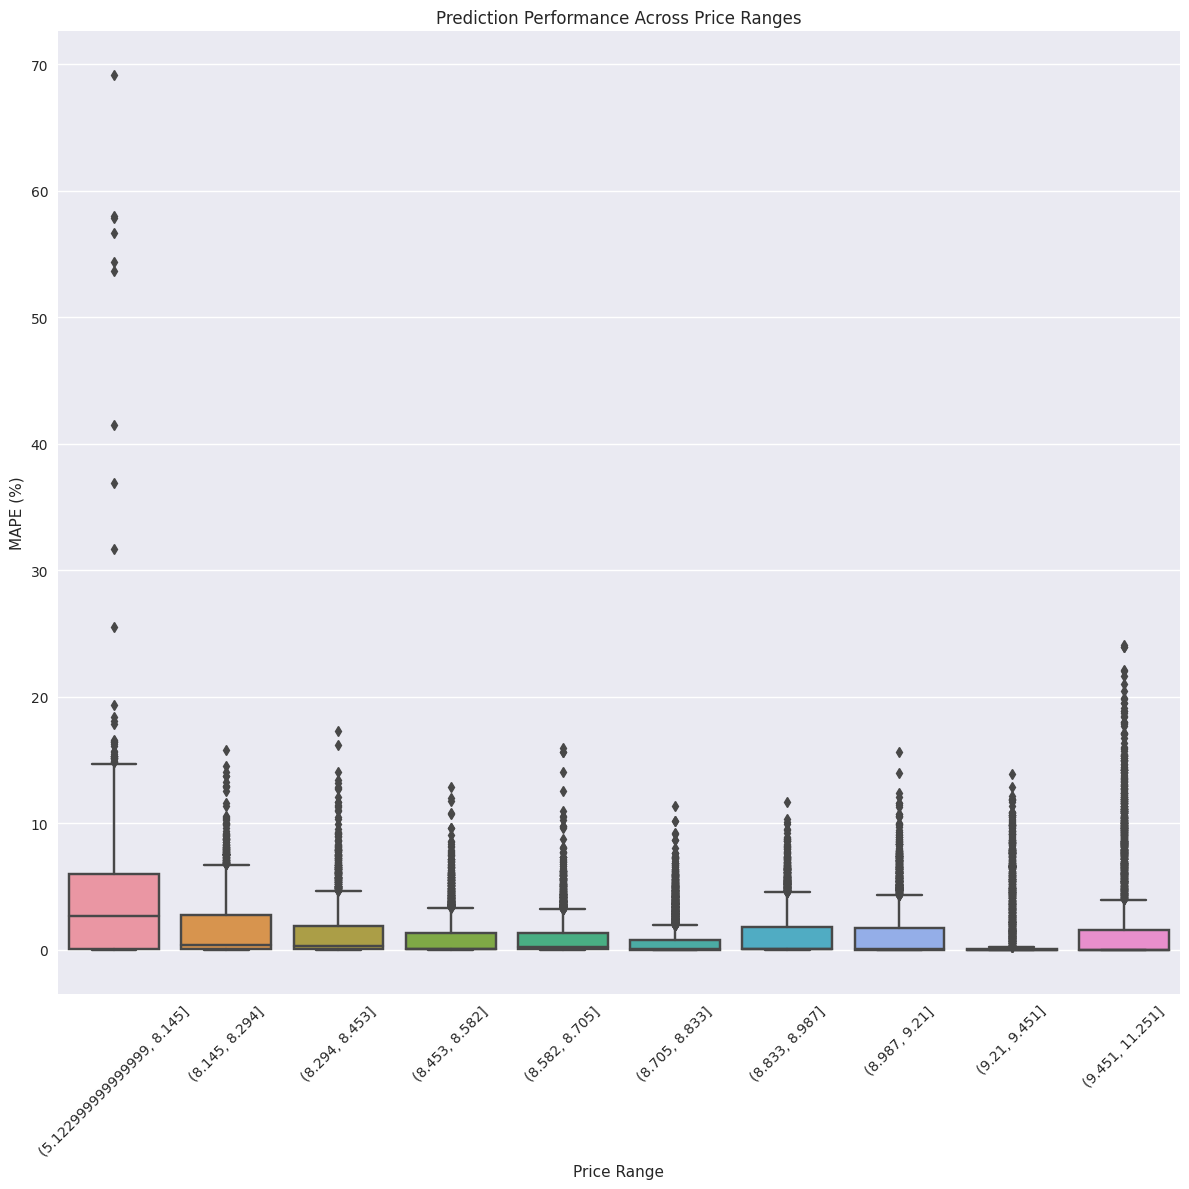


Performance Summary by Price Range:
                            mean  median   std
Range                                         
(5.122999999999999, 8.145]  3.70    2.69  4.47
(8.145, 8.294]              1.65    0.36  2.24
(8.294, 8.453]              1.29    0.29  1.97
(8.453, 8.582]              0.93    0.10  1.52
(8.582, 8.705]              0.98    0.22  1.60
(8.705, 8.833]              0.85    0.08  1.53
(8.833, 8.987]              1.21    0.06  1.92
(8.987, 9.21]               1.19    0.07  2.10
(9.21, 9.451]               0.98    0.03  2.26
(9.451, 11.251]             1.93    0.02  3.79

Overall Performance Metrics:
Median Absolute Percentage Error: 0.12%
Mean Absolute Percentage Error: 1.47%
75th Percentile of Absolute Percentage Error: 1.94%
90th Percentile of Absolute Percentage Error: 4.91%


/tmp/ipykernel_30/3438527903.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = performance_df.groupby('Range')['MAPE'].agg(['mean', 'median', 'std']).round(2)


In [14]:
# 6. Prediction Performance Over Value Ranges
plt.figure(figsize=fig_size)
ranges = pd.qcut(y_test, q=10, duplicates='drop')
performance_df = pd.DataFrame({
    'Range': ranges,
    'MAPE': np.abs((y_test - y_pred) / y_test) * 100
})
sns.boxplot(x='Range', y='MAPE', data=performance_df)
plt.xticks(rotation=45)
plt.xlabel('Price Range')
plt.ylabel('MAPE (%)')
plt.title('Prediction Performance Across Price Ranges')
plt.tight_layout()
plt.show()

# Print summary statistics for different price ranges
print("\nPerformance Summary by Price Range:")
summary_stats = performance_df.groupby('Range')['MAPE'].agg(['mean', 'median', 'std']).round(2)
print(summary_stats)

# Print overall statistics
print("\nOverall Performance Metrics:")
print(f"Median Absolute Percentage Error: {np.median(percentage_error):.2f}%")
print(f"Mean Absolute Percentage Error: {np.mean(percentage_error):.2f}%")
print(f"75th Percentile of Absolute Percentage Error: {np.percentile(percentage_error, 75):.2f}%")
print(f"90th Percentile of Absolute Percentage Error: {np.percentile(percentage_error, 90):.2f}%")